### Pathway Inclusion
An idea to model the problem including pathway information is to use a bipartite graph in which one set corresponds to the samples and another set corresponds to the genes. A node between those two sets exists if the expression level of that gene in the sample is bigger than a threshold $t_e$. The pathway information could be added by connecting gene nodes with each other that contribute to the same pathway based on data from string-db.org. The node is added if the score of this connection is bigger than a threshold $t_p$.

In [142]:
% load_ext autoreload
% autoreload 2
import sys
sys.path.append('..')
from src.data.load_data import get_small_dataset_content, get_big_dataset_content
from src.features.download import get_string_db_identifier, get_associated_genes, save_associated_genes
from src.features.normalize import select_variance_features, scale_df
from src.features.download import load_associated_genes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src.algorithms.bimax import BiMax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df, _ = get_big_dataset_content()

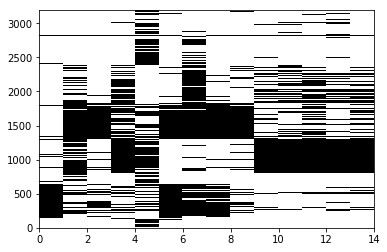

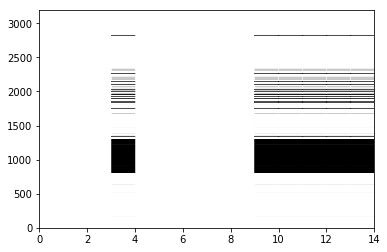

In [3]:
model = BiMax()
df_binary = df > 0
model.fit(df_binary.values)

# get largest bicluster
idx = np.argmax(list(model.rows_[i].sum() * model.columns_[i].sum() for i in range(len(model.rows_))))
bc = np.outer(model.rows_[idx], model.columns_[idx])

# plot data and overlay largest bicluster
plt.pcolor(df_binary.values, cmap=plt.cm.Greys)
plt.show()
plt.pcolor(bc, cmap=plt.cm.Greys, alpha=0.7)
plt.show()

In [4]:
from collections import defaultdict


def find_cliques(graph):
    p = set(graph.keys())
    r = set()
    x = set()
    cliques = []
    for v in degeneracy_ordering(graph):
        neighs = graph[v]
        find_cliques_pivot(graph, r.union([v]), p.intersection(neighs), x.intersection(neighs), cliques)
        p.remove(v)
        x.add(v)
    return sorted(cliques, lambda x: len(x))


def find_cliques_pivot(graph, r, p, x, cliques):
    if len(p) == 0 and len(x) == 0:
        cliques.append(r)
    else:
        u = iter(p.union(x)).next()
        for v in p.difference(graph[u]):
            neighs = graph[v]
            find_cliques_pivot(graph, r.union([v]), p.intersection(neighs), x.intersection(neighs), cliques)
            p.remove(v)
            x.add(v)


def degeneracy_ordering(graph):
    ordering = []
    ordering_set = set()
    degrees = defaultdict(lambda: 0)
    degen = defaultdict(list)
    max_deg = -1
    for v in graph:
        deg = len(graph[v])
        degen[deg].append(v)
        degrees[v] = deg
        if deg > max_deg:
            max_deg = deg

    while True:
        i = 0
        while i <= max_deg:
            if len(degen[i]) != 0:
                break
            i += 1
        else:
            break
        v = degen[i].pop()
        ordering.append(v)
        ordering_set.add(v)
        for w in graph[v]:
            if w not in ordering_set:
                deg = degrees[w]
                degen[deg].remove(w)
                if deg > 0:
                    degrees[w] -= 1
                    degen[deg - 1].append(w)

    ordering.reverse()
    return ordering

In [10]:
NEIGHBORS = [
    [], # I want to start index from 1 instead of 0
    [2, 3, 4],
    [1, 3, 4, 5],
    [1, 2, 4, 5],
    [1, 2, 3],
    [2, 3, 6, 7],
    [5, 7],
    [5, 6],
]
NODES = set(range(1, len(NEIGHBORS)))

MIN_SIZE = 3


def bronker_bosch2(clique, candidates, excluded):
    '''Bron–Kerbosch algorithm with pivot'''
    if not candidates and not excluded:
        if len(clique) >= MIN_SIZE:
            print(clique)
        return
 
    pivot = pick_random(candidates) or pick_random(excluded)
    for v in list(candidates.difference(NEIGHBORS[pivot])):
        new_candidates = candidates.intersection(NEIGHBORS[v])
        new_excluded = excluded.intersection(NEIGHBORS[v])
        bronker_bosch2(clique + [v], new_candidates, new_excluded)
        candidates.remove(v)
        excluded.add(v)


def pick_random(s):
    if s:
        elem = s.pop()
        s.add(elem)
        return elem
    
bronker_bosch2([], set(NODES), set())

{1, 2, 3, 4, 5, 6, 7}
[1, 2, 3, 4]
[5, 2, 3]
[5, 6, 7]


In [41]:
# Without gene inter-connection
MIN_SIZE = 2
NEIGHBORS = [
    [], # I want to start index from 1 instead of 0
    [4],
    [4, 5],
    [5],
    [],
    []
]
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], set(NODES), set())

In [40]:
# With edge between gene vertices
MIN_SIZE = 3
NEIGHBORS = [
    [], # I want to start index from 1 instead of 0
    [4],
    [4, 5],
    [5],
    [5],
    [4]
]
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], set(NODES), set())

[2, 4, 5]


In [69]:
df.head()

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
sample_id,,,,,,,,,,,,,,
0,-0.390651,-0.874771,-0.651031,-1.326890,1.105814,-0.671635,-1.117481,-0.721843,-0.475640,-0.571603,-0.078680,-0.932995,-0.821309,-0.701825
1,-0.546451,-1.045201,-0.651031,-0.846695,1.272846,-0.826816,-0.570226,-0.758942,-0.726717,-0.678175,-1.041723,-0.365608,-0.821309,-0.884311
2,-0.294704,-0.334087,-0.651031,-0.901615,1.147219,0.153893,-0.745637,-0.686860,-0.619298,-0.537545,-0.612176,-0.795993,-0.821309,-0.762039
3,-0.368586,-1.044671,-0.651031,-0.009298,-0.160563,-0.664179,-0.352765,-0.758210,-0.557765,-0.678175,0.419710,-0.104387,-0.648623,-0.032136
4,-0.387323,-1.161929,-0.651031,-1.273913,-0.192725,-0.826816,-1.023866,-0.765135,-0.156699,-0.678175,-0.226191,-0.932995,-0.821309,-0.770710


A sample node $n_s$ has a gene neighbor $n_g$ if the expression of that gene in the sample is bigger than $\tau_e$.

In [54]:
NEIGHBORS = [[]] # I want to start index from 1 instead of 0
TAU_E = 0
gene_neighbor_id_map = {}
# Build from first set of vertices (samples)
for row_index, row in df.iterrows():
    sample_neighbors = []
    for column, item in row.iteritems():
        if item > TAU_E:
            if column not in gene_neighbor_id_map.keys():
                gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
            sample_neighbors.append(gene_neighbor_id_map[column])
    NEIGHBORS.append(sample_neighbors)

# Build from second set of vertices (samples)
for _ in df.columns:
    NEIGHBORS.append([])

In [58]:
MIN_SIZE = 2
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], set(NODES), set())

[1, 3194]
[2, 3194]
[3, 3194]
[3, 3195]
[4, 3200]
[6, 3194]
[6, 3195]
[7, 3194]
[9, 3194]
[13, 3194]
[15, 3194]
[16, 3200]
[16, 3194]
[16, 3190]
[17, 3201]
[17, 3194]
[17, 3195]
[18, 3194]
[19, 3194]
[21, 3194]
[22, 3200]
[24, 3194]
[25, 3194]
[26, 3194]
[27, 3194]
[28, 3195]
[29, 3194]
[29, 3190]
[30, 3193]
[30, 3194]
[30, 3195]
[30, 3201]
[31, 3194]
[32, 3194]
[33, 3194]
[34, 3194]
[34, 3202]
[35, 3194]
[36, 3194]
[37, 3194]
[38, 3194]
[40, 3194]
[42, 3194]
[43, 3194]
[44, 3194]
[45, 3200]
[45, 3194]
[45, 3198]
[46, 3200]
[46, 3195]
[48, 3194]
[49, 3194]
[50, 3194]
[51, 3194]
[51, 3195]
[53, 3194]
[54, 3194]
[54, 3195]
[56, 3194]
[57, 3194]
[58, 3194]
[59, 3194]
[60, 3200]
[60, 3194]
[61, 3194]
[62, 3194]
[65, 3194]
[66, 3194]
[67, 3194]
[68, 3194]
[70, 3194]
[72, 3194]
[73, 3194]
[74, 3194]
[75, 3193]
[75, 3201]
[76, 3194]
[77, 3201]
[77, 3194]
[82, 3194]
[83, 3194]
[84, 3194]
[85, 3194]
[86, 3194]
[87, 3194]
[89, 3194]
[90, 3194]
[91, 3190]
[92, 3194]
[93, 3194]
[94, 3194]
[95, 319

[943, 3194]
[943, 3199]
[944, 3200]
[944, 3201]
[944, 3202]
[944, 3203]
[944, 3191]
[944, 3193]
[944, 3194]
[944, 3196]
[944, 3199]
[945, 3200]
[945, 3201]
[945, 3202]
[945, 3203]
[945, 3193]
[945, 3194]
[945, 3199]
[946, 3200]
[946, 3201]
[946, 3202]
[946, 3203]
[946, 3191]
[946, 3193]
[946, 3194]
[946, 3196]
[946, 3199]
[947, 3200]
[947, 3201]
[947, 3202]
[947, 3203]
[947, 3190]
[947, 3193]
[947, 3194]
[947, 3199]
[948, 3200]
[948, 3201]
[948, 3202]
[948, 3203]
[948, 3191]
[948, 3193]
[948, 3194]
[948, 3199]
[949, 3200]
[949, 3201]
[949, 3202]
[949, 3203]
[949, 3191]
[949, 3193]
[949, 3194]
[949, 3195]
[949, 3199]
[950, 3200]
[950, 3201]
[950, 3202]
[950, 3203]
[950, 3193]
[950, 3194]
[950, 3199]
[951, 3200]
[951, 3201]
[951, 3202]
[951, 3203]
[951, 3191]
[951, 3193]
[951, 3194]
[951, 3199]
[952, 3200]
[952, 3201]
[952, 3202]
[952, 3203]
[952, 3191]
[952, 3193]
[952, 3194]
[952, 3199]
[953, 3200]
[953, 3201]
[953, 3202]
[953, 3203]
[953, 3191]
[953, 3193]
[953, 3194]
[953, 3199]
[954

[1478, 3197]
[1478, 3198]
[1479, 3191]
[1479, 3192]
[1479, 3194]
[1479, 3195]
[1479, 3196]
[1479, 3197]
[1479, 3198]
[1480, 3200]
[1480, 3203]
[1480, 3191]
[1480, 3192]
[1480, 3194]
[1480, 3195]
[1480, 3196]
[1480, 3197]
[1480, 3198]
[1481, 3191]
[1481, 3192]
[1481, 3195]
[1481, 3196]
[1481, 3197]
[1481, 3198]
[1482, 3201]
[1482, 3202]
[1482, 3203]
[1482, 3191]
[1482, 3192]
[1482, 3193]
[1482, 3194]
[1482, 3195]
[1482, 3196]
[1482, 3197]
[1482, 3198]
[1482, 3199]
[1483, 3201]
[1483, 3202]
[1483, 3191]
[1483, 3192]
[1483, 3193]
[1483, 3194]
[1483, 3195]
[1483, 3196]
[1483, 3197]
[1483, 3198]
[1484, 3201]
[1484, 3203]
[1484, 3191]
[1484, 3192]
[1484, 3193]
[1484, 3194]
[1484, 3195]
[1484, 3196]
[1484, 3197]
[1484, 3198]
[1484, 3199]
[1485, 3203]
[1485, 3191]
[1485, 3192]
[1485, 3195]
[1485, 3196]
[1485, 3197]
[1485, 3198]
[1486, 3191]
[1486, 3192]
[1486, 3194]
[1486, 3195]
[1486, 3196]
[1486, 3197]
[1486, 3198]
[1487, 3191]
[1487, 3192]
[1487, 3195]
[1487, 3196]
[1487, 3197]
[1487, 3198]

[2161, 3199]
[2162, 3200]
[2162, 3201]
[2162, 3202]
[2162, 3203]
[2162, 3193]
[2162, 3196]
[2163, 3200]
[2163, 3201]
[2163, 3191]
[2163, 3193]
[2163, 3196]
[2163, 3198]
[2164, 3196]
[2165, 3195]
[2165, 3196]
[2165, 3197]
[2165, 3190]
[2166, 3196]
[2166, 3198]
[2167, 3196]
[2168, 3193]
[2168, 3201]
[2168, 3196]
[2168, 3191]
[2169, 3193]
[2169, 3196]
[2170, 3200]
[2170, 3201]
[2170, 3202]
[2170, 3203]
[2170, 3191]
[2170, 3193]
[2170, 3196]
[2170, 3199]
[2171, 3191]
[2172, 3200]
[2172, 3201]
[2172, 3202]
[2172, 3203]
[2172, 3193]
[2172, 3196]
[2172, 3199]
[2173, 3196]
[2175, 3200]
[2175, 3201]
[2175, 3202]
[2175, 3203]
[2175, 3193]
[2175, 3196]
[2175, 3199]
[2176, 3200]
[2176, 3201]
[2176, 3203]
[2176, 3191]
[2176, 3193]
[2176, 3196]
[2178, 3203]
[2179, 3200]
[2179, 3201]
[2179, 3202]
[2179, 3203]
[2179, 3191]
[2179, 3193]
[2179, 3196]
[2179, 3199]
[2180, 3200]
[2180, 3201]
[2180, 3203]
[2180, 3191]
[2180, 3196]
[2180, 3198]
[2181, 3200]
[2181, 3193]
[2181, 3201]
[2181, 3196]
[2182, 3200]

In [67]:
assert len(NEIGHBORS) == len(df) + len(df.columns) + 1
gene_neighbors = NEIGHBORS[-len(df.columns):]
assert len(gene_neighbors) == len(df.columns)
for x in gene_neighbors:
    assert len(x) == 0

We now need to interconnect the vertices of the gene set. Two gene nodes $n_{g1}$ and $n_{g2}$ are connected if their estimated interconnectivity given by the db_score of the StringDB database is higher than $\tau_i$.

In [149]:
df_associations = pd.DataFrame(index=df.columns, columns=df.columns)
df_associations = df_associations.fillna(0)

# Create gene identifier maps
identifiers = []
for identifier in df.columns:
    ids = [identifier]
    path = os.path.join('../data/external', "{}.json".format(identifier))
    ids.append(json.load(open(path))["identifier"])
    identifiers.append(ids)
    

TAU_I = 0.5
for gene in df.columns:
    associated_genes = load_associated_genes(identifier=gene)
    for associated_gene in associated_genes:
        if associated_gene["dscore"] > TAU_I:
            associated_gene_name = associated_gene["stringId"]
            # Seach the associated gene name in the identifiers map
            for ids in identifiers:
                if associated_gene_name in ids:
                    for gene_id in ids:
                        if gene_id in df_associations.columns:
                            df_associations.loc[gene, gene_id] = 1
df_associations

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
ENSG00000042832,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000086548,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000122852,0,0,0,0,0,0,0,1,1,0,0,0,0,0
ENSG00000128422,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000129824,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000136352,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000157765,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000168878,0,0,1,0,0,0,0,0,1,0,0,0,0,0
ENSG00000185303,0,0,1,0,0,0,0,1,0,0,0,0,0,0
ENSG00000185479,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [161]:
NEIGHBORS = [[]] # I want to start index from 1 instead of 0
TAU_E = 0
TAU_I = 0
gene_neighbor_id_map = {}
# Build from first set of vertices (samples)
for row_index, row in df.iterrows():
    sample_neighbors = []
    for column, item in row.iteritems():
        if item > TAU_E:
            if column not in gene_neighbor_id_map.keys():
                gene_neighbor_id_map[column] = len(df) + 1 + list(row.index).index(column)
            sample_neighbors.append(gene_neighbor_id_map[column])
    NEIGHBORS.append(sample_neighbors)

# Build from second set of vertices (samples)
for col_index, gene in enumerate(df.columns):
    gene_neighbors = []
    for associated_gene in df_associations.columns:
        if df_associations.loc[gene, associated_gene] == 1:
            gene_neighbors.append(gene_neighbor_id_map[associated_gene])
    NEIGHBORS.append(gene_neighbors)

In [162]:
assert len(NEIGHBORS) == len(df) + len(df.columns) + 1
gene_neighbors = NEIGHBORS[-len(df.columns):]
assert len(gene_neighbors) == len(df.columns)

In [166]:
MIN_SIZE = 3
NODES = set(range(1, len(NEIGHBORS)))
bronker_bosch2([], set(NODES), set())

[120, 3192, 3198]
[156, 3192, 3197]
[161, 3192, 3197, 3198]
[162, 3192, 3197]
[163, 3192, 3197, 3198]
[164, 3192, 3197]
[171, 3192, 3197, 3198]
[174, 3192, 3197]
[176, 3192, 3197]
[177, 3192, 3197, 3198]
[178, 3192, 3197, 3198]
[179, 3192, 3197]
[184, 3192, 3197]
[185, 3192, 3197, 3198]
[191, 3192, 3197, 3198]
[193, 3192, 3197]
[194, 3192, 3197]
[196, 3192, 3198]
[198, 3192, 3197]
[199, 3192, 3197]
[200, 3192, 3197]
[206, 3192, 3197]
[207, 3192, 3197, 3198]
[208, 3192, 3197, 3198]
[212, 3192, 3197]
[221, 3192, 3197]
[223, 3192, 3197, 3198]
[224, 3192, 3197, 3198]
[225, 3192, 3197, 3198]
[227, 3192, 3197]
[230, 3192, 3197]
[231, 3192, 3197, 3198]
[232, 3192, 3197, 3198]
[238, 3192, 3197, 3198]
[239, 3192, 3197]
[240, 3192, 3197]
[242, 3192, 3197]
[243, 3192, 3197, 3198]
[245, 3192, 3197, 3198]
[251, 3192, 3197]
[254, 3192, 3197, 3198]
[256, 3192, 3197, 3198]
[262, 3192, 3197, 3198]
[264, 3192, 3197]
[266, 3198, 3197]
[268, 3192, 3197, 3198]
[270, 3192, 3197, 3198]
[271, 3192, 3198]
[272

In [170]:
df.append(df_associations).iloc[[3192-1, 3197-1, 3198-1], :] 

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
ENSG00000122852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSG00000168878,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSG00000185303,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
df.append(df_associations)

,ENSG00000042832,ENSG00000086548,ENSG00000122852,ENSG00000128422,ENSG00000129824,ENSG00000136352,ENSG00000157765,ENSG00000168878,ENSG00000185303,ENSG00000185479,ENSG00000186081,ENSG00000186832,ENSG00000186847,ENSG00000205420
0,-0.390651,-0.874771,-0.651031,-1.326890,1.105814,-0.671635,-1.117481,-0.721843,-0.475640,-0.571603,-0.078680,-0.932995,-0.821309,-0.701825
1,-0.546451,-1.045201,-0.651031,-0.846695,1.272846,-0.826816,-0.570226,-0.758942,-0.726717,-0.678175,-1.041723,-0.365608,-0.821309,-0.884311
2,-0.294704,-0.334087,-0.651031,-0.901615,1.147219,0.153893,-0.745637,-0.686860,-0.619298,-0.537545,-0.612176,-0.795993,-0.821309,-0.762039
3,-0.368586,-1.044671,-0.651031,-0.009298,-0.160563,-0.664179,-0.352765,-0.758210,-0.557765,-0.678175,0.419710,-0.104387,-0.648623,-0.032136
4,-0.387323,-1.161929,-0.651031,-1.273913,-0.192725,-0.826816,-1.023866,-0.765135,-0.156699,-0.678175,-0.226191,-0.932995,-0.821309,-0.770710
5,-0.471526,-1.045772,-0.651031,-0.695362,1.232786,0.008161,-0.801924,-0.789013,-0.492570,-0.678175,-0.903776,-0.622712,-0.721414,-0.884311
6,-0.597166,-1.045679,-0.651031,-1.075242,1.045688,-0.630411,-0.750638,-0.695412,-0.159351,-0.678175,-0.745409,-0.825065,-0.650076,-0.884311
7,-0.223130,-0.856066,-0.452113,-0.978953,-0.079259,-0.589541,-0.861426,-0.551395,-0.361113,-0.543659,-1.041723,-0.649021,-0.535237,-0.684996
8,-0.516868,-1.059777,-0.548391,-0.980375,1.138126,-0.684939,-0.392867,-0.738684,-0.300773,-0.678175,-0.893598,-0.643942,-0.733459,-0.799667
9,-0.627418,-1.161929,-0.651031,-1.163384,-0.218858,-0.826816,-1.127370,-0.739665,-0.592712,-0.678175,-0.853102,-0.932995,-0.821309,-0.775952
